# lda model timing
 - create samples of preprocessed tweets
 - create models with different topic sizes
 - measure coherence for each
 - measure time to get topic for a document for each
 
### plan before running
 - training the models takes a while
 - the sampling method is random, so coherence values are different when you run the notebook more than once
   - *note - the coherence value will give us a value to represent the quality of the topic model once we better define a sample method*

In [1]:
import csv
import time
import pickle
import os

import pandas as pd
import numpy as np

from random import sample

import gensim
import glob
import nltk
import pyLDAvis
import spacy
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import pyLDAvis.gensim

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
from gensim import corpora, models

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
# nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# directory variables

data_path = '.\\data\\'
raw_tweet_file = data_path + 'tweets_01-04.csv'

# load data

In [3]:
doc_path = data_path + 'corpus.pkl'

documents = pickle.load(open(doc_path,'rb'))

In [4]:
documents[:3]

['RT @MaddowBlog"When someone has flu-like symptoms, you want them to seek medical care. If they have one of these junk plans and they know they might be on the hook for more than they can afford to seek that care, a lot of them just won\'t..."\n',
 'Live updates: WHO raises coronavirus risk level to ‘very high’\n\nDear \u2066@realDonaldTrump\u2069 \n\nSure a Dem Hoax...think how great Dems must be to get the World Health Org to agree! Stay healthy along w ur son. Maybe lots of contaminated ppl at ur rallies?  ',
 'RT @dykeistaneven corona virus is in my region now but instagram music probably never will be']

# preprocess

In [5]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in ["rtrt", "https", 'rt']:
            result.append(lemmatize_stemming(token))
    return result

In [6]:
preprocessed_docs = []
print("processing the documents")
for tweet in tqdm(documents):
    preprocessed_docs.append(preprocess(tweet))

processing the documents


In [7]:
# create samples of preprocessed documents

doc_count = len(preprocessed_docs)
print(doc_count)

493525


In [29]:
dictionary = gensim.corpora.Dictionary(preprocessed_docs)

# whole document set

In [9]:
def get_corpus(sample):
    id2word = corpora.Dictionary(sample)
    texts = sample
    corpus = [id2word.doc2bow(text) for text in texts]
    return (corpus, id2word, texts)

In [10]:
model_data_all = get_corpus(preprocessed_docs)

In [11]:
len(model_data_all)

3

# get preprocessed samples

In [12]:
sample_sizes = []

for i in range(0, 4):
    pow = 10 ** i
    sample_sizes.append(100 * pow)
    if 500 * pow < doc_count:
        sample_sizes.append(500 * pow)
    else:
        sample_sizes.append(250 * pow)

sample_sizes

[100, 500, 1000, 5000, 10000, 50000, 100000, 250000]

In [13]:
# get random samples from preprocessed_docs for each sample size

def get_sample(p, n):
    return sample(p, n)

samples = []
for size in sample_sizes:
    samples.append(get_sample(preprocessed_docs, size))
    
samples

[[['biden',
   'liter',
   'say',
   'll',
   'veto',
   'medicar',
   'coronavirus',
   'outbreak',
   'tv',
   'man',
   'elect',
   'novemb'],
  ['global',
   'death',
   'toll',
   'novel',
   'coronavirus',
   'covid',
   'rise',
   'death',
   'mainland',
   'china',
   'death',
   'hong',
   'kong',
   'taiwan',
   'japan',
   'philippin',
   'franc',
   'cnn'],
  ['mermaidmau',
   'scotsirish',
   'tedlieu',
   'realdonaldtrump',
   'princess',
   'ship',
   'injur',
   'ill',
   'probabl',
   'corona',
   'virus',
   'passeng',
   'disembark',
   'morn',
   'cruis',
   'start',
   'afternoon',
   'diamond',
   'princess',
   'isn',
   'go',
   'take',
   'chanc'],
  ['miss', 'clear', 'lesson'],
  ['alvaro_moserth',
   'human',
   'race',
   'shitti',
   'absent',
   'world',
   'begin',
   'thrive'],
  ['frankietwtb', 'korean', 'celebr', 'like', 'experi', 'hell', 'earth'],
  ['robert',
   'get',
   'email',
   'uconn',
   'say',
   'coronavirus',
   'exaust',
   'sick',
   'da

# create data for model from each sample

In [14]:
model_data_l = []

for sample in tqdm(samples):
    model_data_l.append(get_corpus(sample))

# Create LDA models
 - for each sample corpus, we will create a mallet lda model with K topics

In [16]:
os.environ.update({'MALLET_HOME':r'E:\\Github\\TwitterSentiment-TopicModelling\\mallet-2.0.8'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'E:\\Github\\TwitterSentiment-TopicModelling\\mallet-2.0.8\\bin\\mallet' 
#You should update this path as per the path of Mallet directory on your system.

In [17]:
def compute_coherence_values(sample_size, dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    print(sample_size)
    for num_topics in range(start, limit, step):
        print(f'num_topics: {num_topics}')
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
model_dict = {}

for corpus, id2word, texts in tqdm(model_data_l):
    key = 'sample_size_' + str(len(corpus))
    
    model_list, coherence_values = compute_coherence_values(sample_size=key, dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)
    model_dict[key] = (model_list, coherence_values) # tuple contains model list (k topics) and coherence values for each sample size

sample_size_100
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38
sample_size_500
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38
sample_size_1000
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38
sample_size_5000
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38
sample_size_10000
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38
sample_size_50000
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38
sample_size_100000
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38
sample_size_250000
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38



## graph coherence values for each sample-topic size

In [19]:
def graph(coherence_values, title):
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.title(title)
    plt.show()

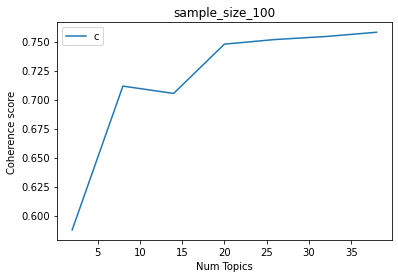

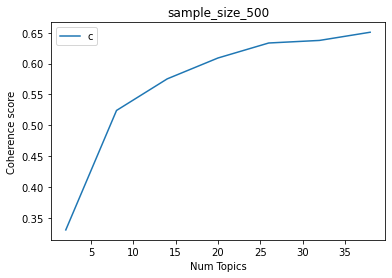

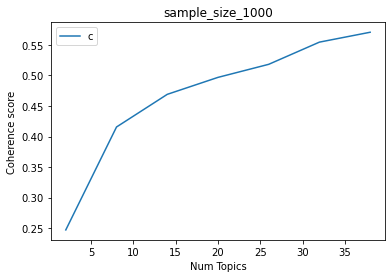

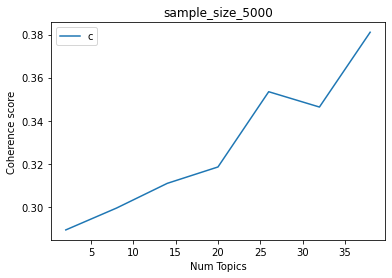

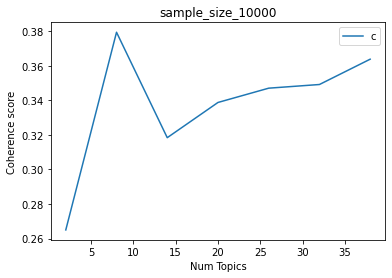

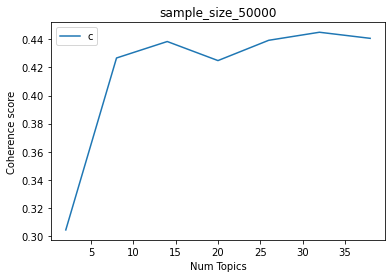

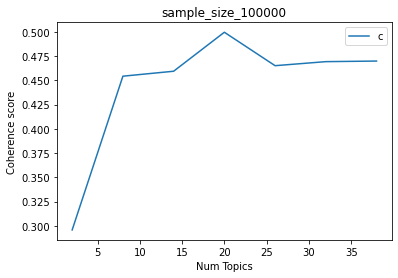

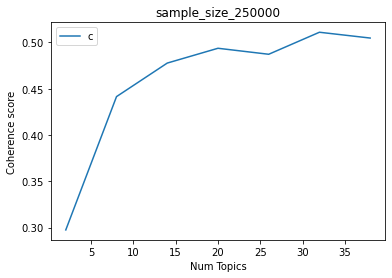

In [20]:
for key in model_dict:
    model_list, coherence_values = model_dict[key]
    graph(coherence_values, key)

## create model for using all 493,525 tweets, as used before
### graph coherence values

In [21]:
# create models
corpus, id2word, texts = model_data_all
models_for_all, coherence_values_all = compute_coherence_values(sample_size=493525, 
                                                        dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

493525
num_topics: 2
num_topics: 8
num_topics: 14
num_topics: 20
num_topics: 26
num_topics: 32
num_topics: 38


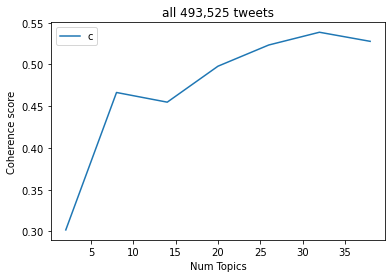

In [22]:
# graph
graph(coherence_values_all, 'all 493,525 tweets')

# measure time to get topic for a tweet

In [23]:
len(models_for_all)

7

In [24]:
count = 0

for key, value in model_dict.items():
    x, y = value
    count += len(y)
    
print(count)

56


In [25]:
run_times = {}

temp_model = models_for_all[0]

In [26]:
def is_topic(text, topic_num, model):
    tokens = preprocess(text.lower())
    bow = dictionary.doc2bow(token for token in tokens)
    result = model[bow][topic_num][1]
    return result

In [27]:
temp_tweet_text = documents[0]
topic_num = 0

In [30]:
is_topic(temp_tweet_text, topic_num, temp_model)

0.5677083333333334

In [31]:
# num_topics: 2
# num_topics: 8
# num_topics: 14
# num_topics: 20
# num_topics: 26
# num_topics: 32
# num_topics: 38

run_times['sample_size_493525'] = []

topic_count = 2
for model in models_for_all:
    start = time.time()
    is_topic(temp_tweet_text, topic_num, model)
    finish = time.time() - start
    run_times['sample_size_493525'].append((topic_count, finish))
    topic_count += 6
    
for key, value in model_dict.items():
    run_times[key] = []
    x, y = value
    topic_count = 2
    for m in x:
        start = time.time()
        is_topic(temp_tweet_text, topic_num, m)
        finish = time.time() - start
        run_times[key].append((topic_count, finish))
        topic_count += 6

# graph times

In [46]:
def graph_times(title, times):
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, times)
    plt.xlabel("Num Topics")
    plt.ylabel("time to get topic in seconds")
    plt.legend(("time"), loc='best')
    plt.title(title)
    plt.show()

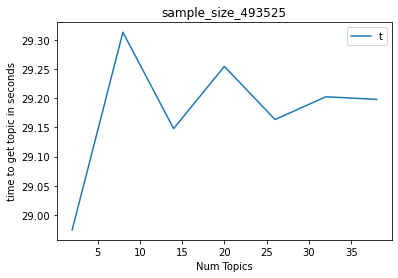

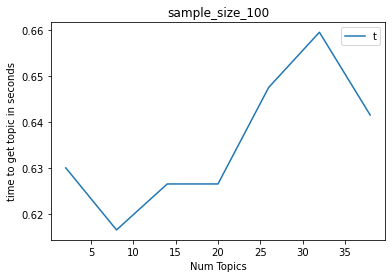

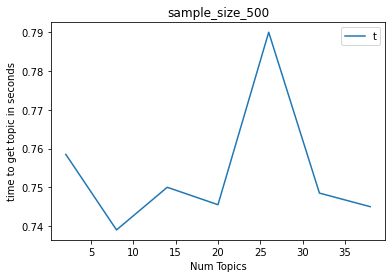

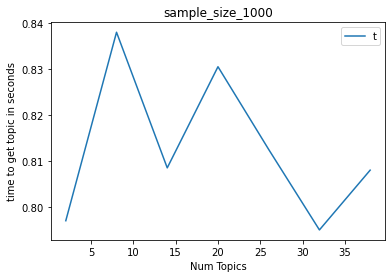

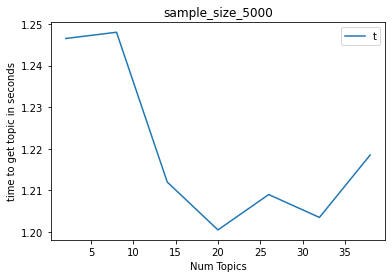

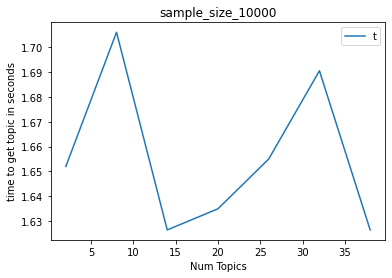

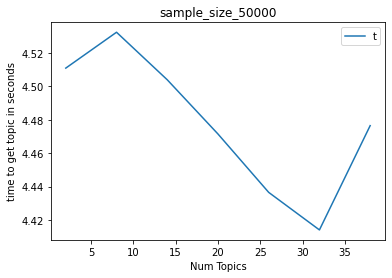

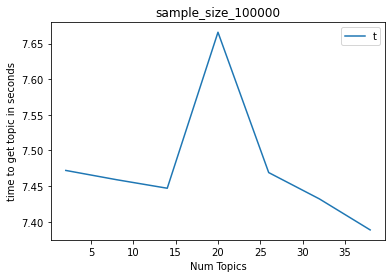

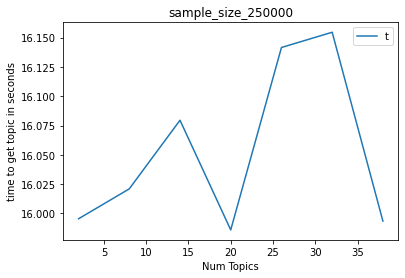

In [47]:
for k, v in run_times.items():
    times = []
    for t in v:
        topic_count, topic_time = t
        times.append(topic_time)
    graph_times(k, times)